In [174]:
using QuantumOptics
using WignerSymbols
using Plots
using LaTeXStrings
using Random
using Statistics
using LinearAlgebra
using StatsBase
pyplot();

## Sub-Doppler cooling in a lin$\perp$lin molasses configuration (free space)

In [159]:
δ = -0.5;
Ω = 0.25;
s₀ = 2 * Ω^2;
s = 2*Ω^2 / (4*δ^2 + 1);

We need a basis that includes the three hyperfine ground states $|1, -1\rangle, |1, 0\rangle, |1, 1\rangle$ and the five hyperfine excited states: $|2, -2\rangle \cdots |2, 2\rangle$.
To this order we'll set up an 8-dimensional generic basis, where we'll stick in the couplings by hand. 

In [160]:
Fg = 1//2;
Fe = 3//2;
nStates = Int(2*(Fg + Fe) + 2);
gStates= [[Fg, mFg] for mFg in [-Fg:Fg;]];
eStates = [[Fe, mFe] for mFe in [-Fe:Fe;]];
states = [gStates; eStates];
sbasis = GenericBasis(nStates);

In [161]:
σmincoupling = [[[j+(2*Fg + 1) i 1. * clebschgordan(gStates[i][1], gStates[i][2], 1, -1, eStates[j][1], eStates[j][2] )] for i in [1:Int(2*Fg + 1);]] for j in [1:Int(2*Fe + 1);]];
σmincoupling = collect(Iterators.flatten(σmincoupling));
VminMat = vcat(σmincoupling...);
Vminhalf = Ω / sqrt(2) * SparseOperator(sbasis, complex(sparse(VminMat[:, 1], VminMat[:, 2], VminMat[:, 3], nStates, nStates)));
Vmintot(z) = cos(z) * ( Vminhalf + dagger(Vminhalf) );

σpluscoupling = [[[j+(2*Fg + 1) i 1. * clebschgordan(gStates[i][1], gStates[i][2], 1, 1, eStates[j][1], eStates[j][2] )] for i in [1:Int(2*Fg + 1);]] for j in [1:Int(2*Fe + 1);]];
σpluscoupling = collect(Iterators.flatten(σpluscoupling));
VplusMat = vcat(σpluscoupling...);
Vplushalf = Ω / sqrt(2) * SparseOperator(sbasis, complex(sparse(VplusMat[:, 1], VplusMat[:, 2], VplusMat[:, 3], nStates, nStates)));
Vplustot(z) = sin(z) * ( Vplushalf + dagger(Vplushalf) );

Define the Hamiltonian and force. The force is defined clasically as
$$
    F = -\langle \nabla\mathcal{H} \rangle.
$$

In [162]:
diagonalTerm = SparseOperator(sbasis, complex(Matrix(Diagonal([zeros(Int(2*Fg + 1)); ones(Int(2*Fe + 1))]))));

In [163]:
H(z) = Vplustot(z) + Vmintot(z) - δ * diagonalTerm;
F(z) = sin(z) * (Vminhalf + dagger(Vminhalf)) - cos(z) * (Vplushalf + dagger(Vplushalf));

### Decay, dephasing, and jump operators
The full evolution of the density matrix $\rho$ is given by the master equation
$$
    \frac{d\rho}{dt} = -i\left[\mathcal{H}, \rho \right] + \sum_L L\rho L^\dagger - \frac{1}{2} \left\{ L^\dagger L, \rho \right\}.
$$
where $L$ are the quantum jump operators. Due to our choice of units, the values that enter in the matrices are simply the Clebsch-Gordan coefficients. The rate (which is specified separately) is unity. We don't really need to bother with this master equation itself, since QuantumOptics.jl will do it for us.

We obtain the quantum jump operators by iterating over all the possible couplings, and using those with nonzero Clebsch-Gordan coefficients. To that extent, we need the couplings by $\pi$ photons as well. Decay paths with the same polarization are combined into a single jump operator.

In [164]:
πcoupling = [[[j+(2*Fg + 1) i 1. * clebschgordan(gStates[i][1], gStates[i][2], 1, 0, eStates[j][1], eStates[j][2] )] for i in [1:Int(2*Fg + 1);]] for j in [1:Int(2*Fe + 1);]];
πcoupling = collect(Iterators.flatten(πcoupling));

L = [];

# Loop over all excited states, and find paths down
for couplings in (σmincoupling, σpluscoupling, πcoupling)
    cpls = vcat(couplings...);
    
    # Combine all decays with a particular polarization into one jump operator (select nonzero elements)
    cpls = cpls[ cpls[:, 3] .> 0., : ]
    
    # Construct the jump operator describing that decay
    L = vcat(L, SparseOperator(sbasis, sparse(cpls[:, 2], cpls[:, 1], complex(cpls[:, 3]), nStates, nStates)));
end

rate = ones(3);
Ldagger = dagger.(L);

#### Set up quantum part
Define a normalization function that works both for kets and for density matrices.

In [165]:
normψ(ψ::Ket) = dagger(ψ) * ψ
normψ(ψ::DenseOperator) = tr(ψ)

normψ (generic function with 2 methods)

In [166]:
function fquantum_master(t, ψ, u)
    z = u[1];
    H = Vplustot(z) + Vmintot(z) - δ * diagonalTerm;
    return H, L, Ldagger
end

fquantum_master (generic function with 1 method)

### The classical part
Below we define the classical part of the problem. `QuantumOptics.jl` encodes the classical variables in a vector `u`. We define the first component as the position, and the second component as the momentum. Above we already introduced the classical force due to the light fields, here we add the harmonic confinement to that. We need to take some care with units, though. We already defined the mass unit through $\hbar$, and the energy through $\hbar\Gamma$. Therefore, any force is in units of $\hbar k\Gamma$. This means that we cannot simply put masses in units of the mass of rubidium, and need to use the dimensionless mass:
$$
    \tilde{m} = \frac{m\Gamma}{\hbar k^2},
$$
which, for $^{87}$Rb is roughly 800. In dimensionless units, our equations of motion are:
\begin{align}
    \dot{x} &= p/m \\
    \dot{p} &= F.
\end{align}

Since we're expecting to achieve sub-Doppler temperatures, it might be important to weight the probability of absorption from a photon from the left and from the right. We can use the Doppler shift $kp/m$ for this (in our units simply $p/m$), by inserting it into the Lorentzian lineshape. In our units this is proportional to $\frac{1}{1+4\Delta^2}$, where $\Delta = \delta \pm p/m$, and where we choose either the plus or minus sign to denote the Doppler shift for the beam coming from the right or left.

In [228]:
dimlessmass = 796.89;
dimlessmass = 200.;

function fclassical(t, ψ, u, du)
    # u[1] = z
    # u[2] = p
    du[1] = u[2]/dimlessmass;
    du[2] = real(expect(F(u[1]), ψ)) / normψ(ψ);
    du[3] = 0.
    return nothing
end

function fjump_classical(t, ψ, u, i)
    p3D = rand(3) .- 0.5;
    normalize!(p3D);
    u[2] += p3D[1];
    u[3] += 1.;
    return nothing
end

# Generate probabilities for all recoil processes
σkicks = [-1. 0. 0. 0. 1.];
#σkicks = [σkicks .- 1. σkicks .+ 1.];
πkicks = [-1. 0. 0. 0. 0. 0. 0. 0. 0. 1.];
#πkicks = [πkicks .- 1. πkicks .+ 1.];

function fjump_classical(t, ψ, u, i)
    # Use the Doppler shift to weight the probability of left/right absorption
    δdop = real(u[2])/dimlessmass;
    weights = 1 ./ (1 .+ 4.0.*(δ .+ [δdop, -δdop]).^2)
    abskick = sample([-1., 1.], Weights(weights));
    
    if i == 1 || i == 2   # A σ₊₋ photon was emitted
        u[2] += σkicks[ rand(1:end) ] + abskick;
    elseif i == 3         # A π photon was emitted
        u[2] += πkicks[ rand(1:end) ] + abskick;
    end
    u[3] += 1.;
    return nothing
end

fjump_classical (generic function with 1 method)

In [227]:
weights = [0.1, 0.2]
sample([-1., 1.], Weights(weights))

1.0

### Launch simulations
We can compare a master-equation evolution without recoil effects to a bunch of averaged Monte Carlo trajectories (inspired by [this example](https://docs.qojulia.org/examples/cavity-cooling/#Cavity-cooling-of-a-two-level-atom-1) from the QuantumOptics.jl documentation).

In [224]:
p0 = 0.;    # Initial momentum
x0 = 0.;     # Initial position

ψ₀ = Ket(sbasis, [1; 1; zeros(nStates - 2)])/sqrt(2);
u0 = ComplexF64[x0, p0, 0.];
ρ_sc = semiclassical.State(ψ₀, u0);

fout = (t, psi) -> real(psi.classical[2]);

T = [0 : 0.1 : 1000;];
#tout, p_mastereq = semiclassical.master_dynamic(T, ρ_sc, fquantum_master, fclassical; fout = fout);

In [229]:
Ntraj = 500;
Ωs = [0.25];
T = [0. : 0.1 : 6000;];

p_MCsq = [zeros(length(T)) for i in 1:length(Ωs)]
p_MC = [zeros(length(T)) for i in 1:length(Ωs)]

@time for j = 1:length(Ωs)
    Ω = Ωs[j]
    for i = 1:Ntraj
        t_, p_ = semiclassical.mcwf_dynamic(T, ρ_sc, fquantum_master, fclassical, fjump_classical; fout = fout);
        #p_ = real.([ψ.classical[2] for ψ in ρ]);

        p_MC[j] += p_ / Ntraj;
        p_MCsq[j] += p_.^2 / Ntraj;
        if i % 10 == 0
            print(Ω, "\t", i, "\n");
        end
    end
    IJulia.clear_output()
end

465.694287 seconds (2.79 G allocations: 233.034 GiB, 18.15% gc time)


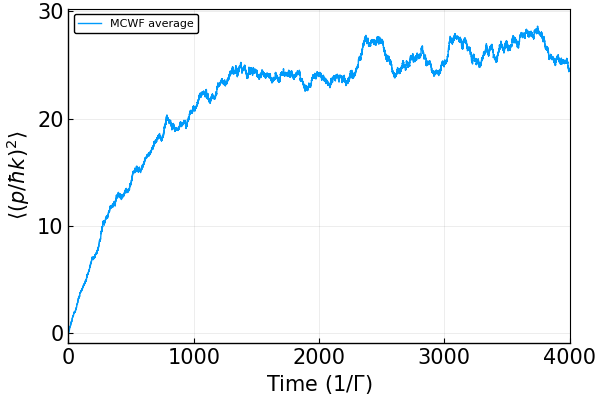

In [230]:
plot(T, p_MCsq[1], label = "MCWF average",
    frame = true,
    xlabel = L"Time ($1/\Gamma$)",
    ylabel = L"$\langle \left(p/\hbar k \right)^2\rangle$",
    yaxis = font(15),
    xaxis = font(15),
    xlim = (0, 4000))